<a href="https://colab.research.google.com/github/Samarth-Sharma-G/258_Final_Project/blob/main/258ProjectEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Project Idea: Building a deep learnign network capabale of identifying different types of defects in waffers (computer chips).

Dataset Link : https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map


Types of Defects: Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full, none

In [ ]:
#reading the data
df = pd.read_pickle('/content/drive/MyDrive/LSWMD.pkl')

In [ ]:
df.shape

(811457, 6)

In [ ]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


Each row has an Image saved as an Array and die Size,lot nunebr train-test labels and failure type.

In [ ]:
df['dieSize'].value_counts()

dieSize
710.0     66961
515.0     45725
712.0     42572
1513.0    39322
776.0     29513
          ...  
2322.0        1
2309.0        1
2277.0        1
2273.0        1
586.0         1
Name: count, Length: 1266, dtype: int64

As we are building an Image classifier we are not interested in other such as waferIndex and lotName

In [ ]:
df = df.drop(['waferIndex', 'lotName'], axis=1)

We have dies of different Sizes, if we want to make an image clasifier thats common is capable of working on all the images

In [ ]:
#finding the dimensions of all the images
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return dim0, dim1


df['waferMapDim'] = df.waferMap.apply(find_dim)

In [ ]:
df['waferMapDim'].value_counts()

waferMapDim
(32, 29)    108687
(25, 27)     64083
(49, 39)     39323
(26, 26)     30078
(30, 34)     29513
             ...  
(53, 70)         1
(99, 69)         1
(38, 50)         1
(45, 47)         1
(27, 71)         1
Name: count, Length: 632, dtype: int64

In [ ]:
#finding the total number of distinct shapes of images we have
df['waferMapDim'].nunique()

632

These are too many different sizes

In [ ]:
df['dieSize'].value_counts()

dieSize
710.0     66961
515.0     45725
712.0     42572
1513.0    39322
776.0     29513
          ...  
2322.0        1
2309.0        1
2277.0        1
2273.0        1
586.0         1
Name: count, Length: 1266, dtype: int64

For sake of simiplicity and getting to proff of cocnept quikcer, let us just look at tthe image of shape 26x26, mainly out of all square shapes in the dataset, this shape has the highest number of records

In [ ]:
sub_df = df[df['waferMapDim'] == (26, 26)].copy()

In [ ]:
sub_df.head()

,waferMap,dieSize,trianTestLabel,failureType,waferMapDim
150,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,[[Training]],[[none]],"(26, 26)"
151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,[[Training]],[[none]],"(26, 26)"
152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,[[Training]],[[none]],"(26, 26)"
153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,[[Training]],[[none]],"(26, 26)"
154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,[[Training]],[[none]],"(26, 26)"


In [ ]:
#performing a squeze to get Failuretype sand test train albels out of the nested list
f_squeeze = lambda x: str(np.squeeze(x))
sub_df["failureType"] = sub_df["failureType"].map(f_squeeze)
df["trianTestLabel"] = sub_df["trianTestLabel"].map(f_squeeze)


# Mapping dictionaries
mapping_type = {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3, 'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': 8}
mapping_traintest = {'Training': 0, 'Test': 1}


In [ ]:
sub_df['failureType'].value_counts()

failureType
[]           15712
none         13489
Loc            297
Edge-Loc       296
Center          90
Random          74
Scratch         72
Edge-Ring       31
Near-full       16
Donut            1
Name: count, dtype: int64

In [ ]:
#we ll there are a number of records which are empty []. let us drop them
sub_df = sub_df[sub_df['failureType'] != '[]']

In [ ]:
sub_df['failureType'].value_counts()

failureType
none         13489
Loc            297
Edge-Loc       296
Center          90
Random          74
Scratch         72
Edge-Ring       31
Near-full       16
Donut            1
Name: count, dtype: int64

In [ ]:
#TODO: Visualize one image of each failure type

<Axes: xlabel='failureType', ylabel='count'>

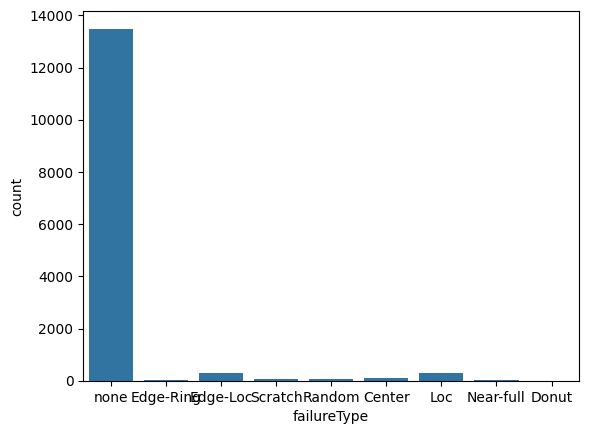

In [ ]:
#let us visualize it
sns.countplot(x='failureType', data=sub_df)

the class immbalance is too great to be addressed effectively, let us pivot, instead of classifying which defect it is we can change out approach to classify if a chip has a defect or no.

In [ ]:
#replace all the labels other than none, with word failure
sub_df['failureType'] = sub_df['failureType'].apply(lambda x: 'failure' if x != 'none' else x)


In [ ]:
sub_df['failureType'].value_counts()

failureType
none       13489
failure      877
Name: count, dtype: int64

In [ ]:
# prompt: I want to down sample none type to 900

import pandas as pd
import numpy as np
# Get the indices of the rows with the label "none"
none_indices = sub_df[sub_df['failureType'] == 'none'].index

# Randomly select 900 indices from the none_indices
selected_indices = np.random.choice(none_indices, 900, replace=False)

# Create a new DataFrame with the selected rows
sub_df_downsampled = sub_df.loc[selected_indices]

# Concatenate the downsampled DataFrame with the rows that are not "none"
sub_df_downsampled = pd.concat([sub_df_downsampled, sub_df[sub_df['failureType'] != 'none']], ignore_index=True)

# Print the value counts of the failureType column
print(sub_df_downsampled['failureType'].value_counts())


failureType
none       900
failure    877
Name: count, dtype: int64


In [ ]:
#reshaping the image and extracting them as numpy array
import numpy as np
images = np.ones((sub_df_downsampled.shape[0], 26, 26, 1))
for i in range(sub_df_downsampled.shape[0]):
  images[i] = np.array(sub_df_downsampled['waferMap'][i]).reshape(26, 26, 1)


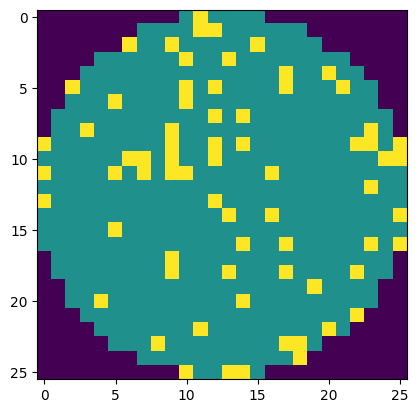

In [ ]:
plt.imshow(images[1])

In [ ]:
#mapping none to 0  and failure to 1 and then doing the same with them
mapping_failure = {'none': 0, 'failure': 1}
sub_df_downsampled['failureType'] = sub_df_downsampled['failureType'].map(mapping_failure)

In [ ]:
sub_df_values  = sub_df_downsampled['failureType'].values

In [ ]:
import pickle

with open('/content/drive/MyDrive/sub_df_downsampled.pkl', 'wb') as f:
  pickle.dump(sub_df_downsampled, f)


In [ ]:
import pickle

# Save images as a pickle file
with open('/content/drive/MyDrive/images_extracted.pkl', 'wb') as f:
  pickle.dump(images, f)

# Save sub_df_values as a pickle file
with open('/content/drive/MyDrive/images_labels.pkl', 'wb') as f:
  pickle.dump(sub_df_values, f)
